# 2023-09-09 15 - Tables and plots for paper - FIXED ERM.ipynb
Copy of `2023-09-06 12 - Tables and plots for paper.ipynb`

## Fetching runs

In [25]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer"
workspace = "alelab"

experiment_tags = [
    # To get the constrained runs (1 seed)
    "e1_weather_10e_statinformed",
    "e2_electricity_10e_statinformed",
    # To get the ERM runs (1 seed)
    "e5_electricity_10e_ermfix_seeds1",
    "e6_weather_10e_ermfix_seeds1"
    ]

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",
                {"$and": [
                    {"tags": {"$in": experiment_tags}},
                    {"state": "finished"}
                ]})

def tag_experiment(run):
    for tag in experiment_tags:
        if tag in run.tags:
            return tag
    return ''

all_runs = []
run_counter = 0
for run in tqdm(runs):
    run_counter += 1
    for split in ["train", "test","val"]:
        for metric in ["mse",]:
            pred_len = run.config["pred_len"]
            metrics = np.zeros(pred_len)
            for i in range(pred_len):
                run_dict = {**run.config}
                #run_dict["constraint_level"] = constraint_level
                run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                run_dict["step"]=i
                run_dict["epoch"]=run.summary["epoch"]
                run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                run_dict["split"] = split
                run_dict["run_id"] = run.id
                # Get either Constrained/ or ERM/ from the run name, then append model name.
                #print("run.name", run.name)
                #debug if ERM run
                run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                run_dict["sweep_id"] = run.sweep.id
                #print("Algorithm", run_dict["Algorithm"])

                # Get the experiment tag
                run_dict["experiment_tag"] = tag_experiment(run)

                # To better plot constrained vs ERM
                #TODO this is a hack while I consolidate the tags. 
                run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                all_runs.append(run_dict)
print(f"Fetched {run_counter} runs")
df = pd.DataFrame(all_runs)
print(f"Total records: {(df.shape)}")
print(f"Total runs: {df.run_id.nunique()}")

KeyboardInterrupt: 

In [ ]:
# Filtering the unnecessary ERM runs:
df[df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])].groupby(['type']).run_id.nunique()

type
Constrained    48
ERM            16
Name: run_id, dtype: int64

Looks good:

In [ ]:
only_constrained_on_first_runs=(df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])) & (df.type == "Constrained")
not_e1_e2 = ~df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])
df[only_constrained_on_first_runs | not_e1_e2] \
    .groupby(['experiment_tag','type']).run_id.nunique().reset_index()

,experiment_tag,type,run_id
0,e1_weather_10e_statinformed,Constrained,24
1,e2_electricity_10e_statinformed,Constrained,24
2,e5_electricity_10e_ermfix_seeds1,ERM,8
3,e6_weather_10e_ermfix_seeds1,ERM,8


In [ ]:
df = df[only_constrained_on_first_runs | not_e1_e2]

In [ ]:
df[['run_id',"sweep_id",'Algorithm','model','constraint_level','pred_len','epoch',"split"]] \
    .drop_duplicates().sort_values(["pred_len",'Algorithm','model',"constraint_level"])

,run_id,sweep_id,Algorithm,model,constraint_level,pred_len,epoch,split
40032,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,train
40128,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,test
40224,iij1xyjo,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.157,96,10,val
39456,4a1mgu20,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.169,96,10,train
39552,4a1mgu20,jk3es6p9,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,0.169,96,10,test
...,...,...,...,...,...,...,...,...
720,bmmkx327,kddcveaj,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,test
1440,bmmkx327,kddcveaj,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,val
8064,0k2akp1n,1zde3eug,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,train
8784,0k2akp1n,1zde3eug,StatInformed-ERM-10e Reformer,Reformer,-1.000,720,10,test


## Data processing
1. Impute seed for the first batch of runs
2. Create aggregate dataset of metrics per experiment `(data_path,model,pred_len,constraint_level)`
3. Add any other useful columns

In [ ]:
df.seed.unique()

array([ 0., nan])

It seems that the seeds didn't get properly logged, but we can confirm that the results have variance so it's not just the same run three times.

In [ ]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

,model,constraint_level,pred_len,data_path,mean
23,Autoformer,0.556,96,weather.csv,[0.475]
11,Autoformer,0.173,192,electricity.csv,[0.176]
55,Reformer,0.556,96,weather.csv,[0.438]
28,Autoformer,0.741,336,weather.csv,[0.652]
42,Reformer,0.170,96,electricity.csv,[0.183]
27,Autoformer,0.698,720,weather.csv,[0.788]
2,Autoformer,-1.000,192,electricity.csv,[0.183]
25,Autoformer,0.665,192,weather.csv,[0.595]
10,Autoformer,0.170,96,electricity.csv,[0.152]
6,Autoformer,-1.000,720,electricity.csv,[0.223]


### Broadcast ERM runs with constraint levels (`df_to_plot`)

In [ ]:
df_constrained = df.query('type=="Constrained"').copy()
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_level']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_level']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*3}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*3}")

(48384, 64)

Three constraints per experiment, broadcasted dataset size be equal to 48384


(96768, 64)

Final dataset size should be equal to 96768


### Add constraint violation metric

In [ ]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
1,bmmkx327,Reformer,ERM,0,0.230896,0.230,0.000896,1
2,bmmkx327,Reformer,ERM,0,0.230896,0.215,0.015896,1
2160,bmmkx327,Reformer,ERM,0,0.360436,0.246,0.114436,1
2161,bmmkx327,Reformer,ERM,0,0.360436,0.230,0.130436,1
2162,bmmkx327,Reformer,ERM,0,0.360436,0.215,0.145436,1


For Constrained


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
16848,0ilat545,Reformer,Constrained,0,0.268508,0.246,0.022508,1
16849,0ilat545,Reformer,Constrained,1,0.258101,0.246,0.012101,1
16850,0ilat545,Reformer,Constrained,2,0.250182,0.246,0.004182,1
16851,0ilat545,Reformer,Constrained,3,0.247950,0.246,0.001950,1
16852,0ilat545,Reformer,Constrained,4,0.247160,0.246,0.001160,1


### Add infeasible rate (missing on ERM)

In [ ]:
# # Add infeasible count in the last step
# dd=df_to_plot.query('type=="ERM" and split=="test" and pred_len==96').copy()
# dd['is_infeasible'] = (dd.constraint_violation>0)*1
# dd[['run_id','pred_len',"constraint_level","split",'step','mse','constraint_violation','is_infeasible']].sort_values(["run_id","constraint_level","split","step"]).head(98)

### Aggregate results
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [ ]:
#TO DO in progress: how to compute the infeasibility rate for the ERM runs. I already have the is_infeasible flag on each step. Need to average properly.
# Can be cross checked in constrained runs.
df_to_plot.groupby(["Algorithm",'run_id', #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"])['is_infeasible'].sum()

Algorithm                                            run_id    model       type         constraint_level  pred_len  data_path        split
Electricity-StatInformed-10e-Constrained Autoformer  08uz85ap  Autoformer  Constrained  0.245             336       electricity.csv  test      1
                                                                                                                                     train     0
                                                                                                                                     val       1
                                                     4a1mgu20  Autoformer  Constrained  0.169             96        electricity.csv  test     40
                                                                                                                                     train     1
                                                                                                                                        

In [ ]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(288, 12)

(288, 14)

,Algorithm,model,type,constraint_level,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,mean_infeasible_rate,std_infeasible_rate,run_count
0,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,test,0.16279,NaN,0.00695,NaN,0.48826,NaN,1.0
1,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,train,0.12660,NaN,0.00023,NaN,0.02083,NaN,1.0
2,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,val,0.16284,NaN,0.00700,NaN,0.50026,NaN,1.0
3,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,test,0.16584,NaN,0.00190,NaN,0.33162,NaN,1.0
4,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,train,0.13051,NaN,0.00005,NaN,0.01042,NaN,1.0


## Plots

### ERM vs. Constrained on test split (single run)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

In [ ]:
unique_run_ids = df_to_plot.sample(frac=1,random_state=42).groupby(["model",'type',"constraint_level","pred_len","data_path"])['run_id'].head(1)

In [ ]:
# display(df.query('type=="Constrained" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [ ]:
# # Query ERM runs with pred_len96 constraint_level: 0.17, on weather.csv
# display(df.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))
# display(df_to_plot.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [ ]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

,model,constraint_level,pred_len,data_path,mean
5,Autoformer,-1.000,336,weather.csv,[0.67]
50,Reformer,0.246,720,electricity.csv,[0.232]
44,Reformer,0.184,192,electricity.csv,[0.209]
22,Autoformer,0.553,192,weather.csv,[0.614]
36,Reformer,-1.000,336,electricity.csv,[0.211]
56,Reformer,0.567,192,weather.csv,[0.477]
57,Reformer,0.665,192,weather.csv,[0.505]
20,Autoformer,0.516,96,weather.csv,[0.479]
0,Autoformer,-1.000,96,electricity.csv,[0.14]
63,Reformer,0.970,336,weather.csv,[0.634]


In [ ]:
## Was getting 288 steps on ERM because of the 3 seeds (96*3=288)

[0.17  0.169 0.157]


### Dataset: electricity.csv pred_len: 96 constraint_level: 0.17

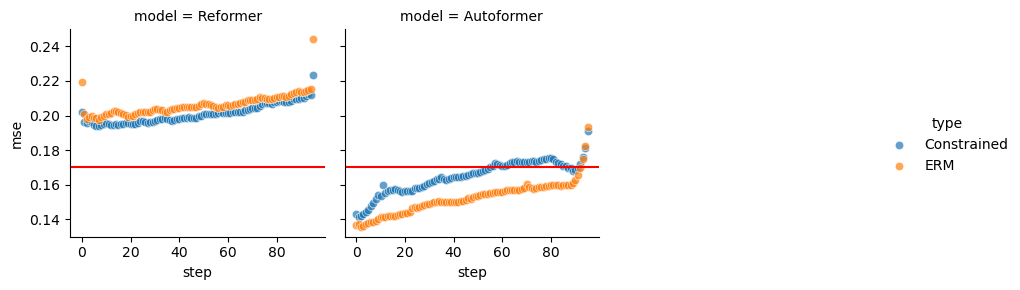

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.169

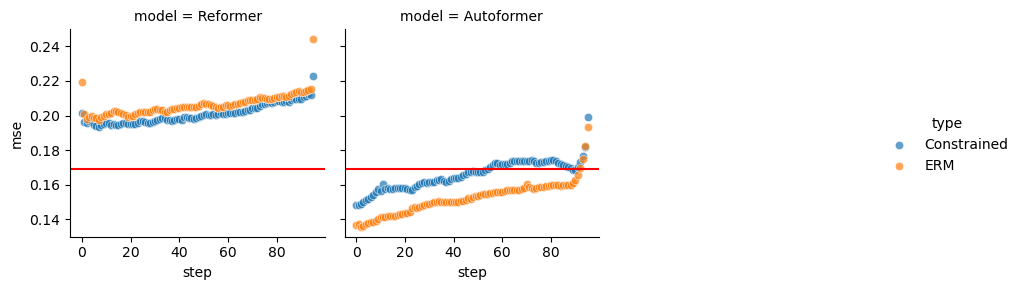

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.157

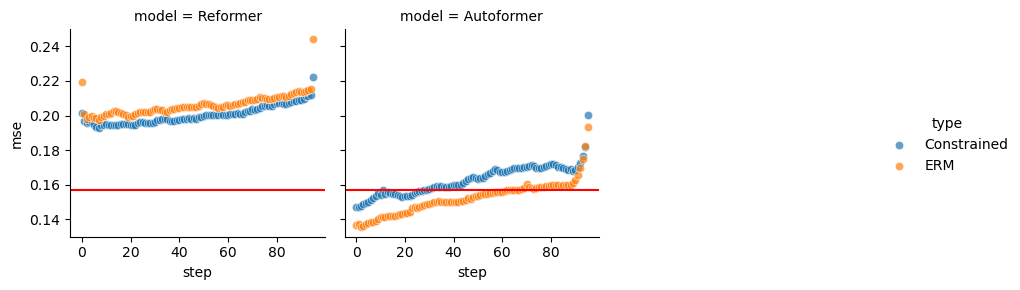

[0.2   0.184 0.173]


### Dataset: electricity.csv pred_len: 192 constraint_level: 0.2

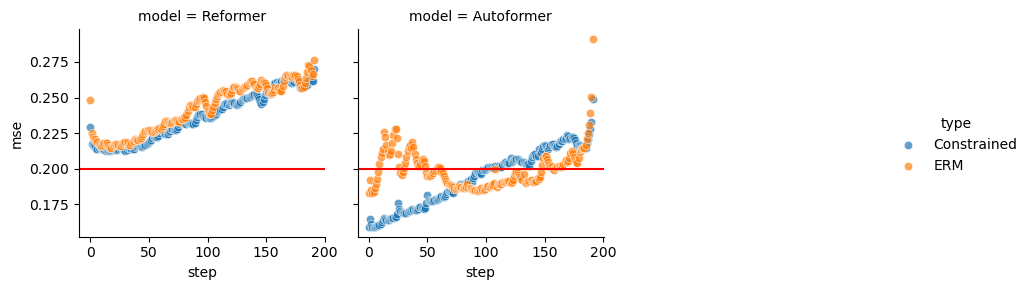

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.184

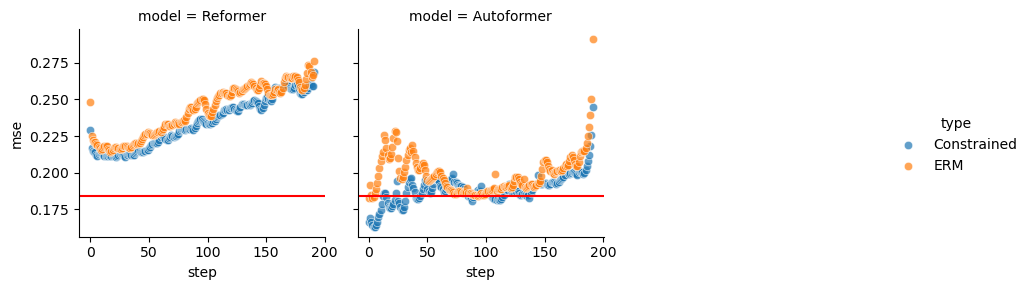

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.173

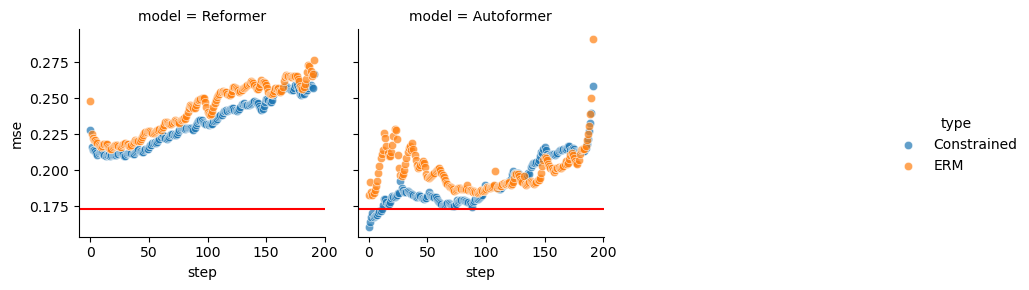

[0.256 0.245 0.232]


### Dataset: electricity.csv pred_len: 336 constraint_level: 0.256

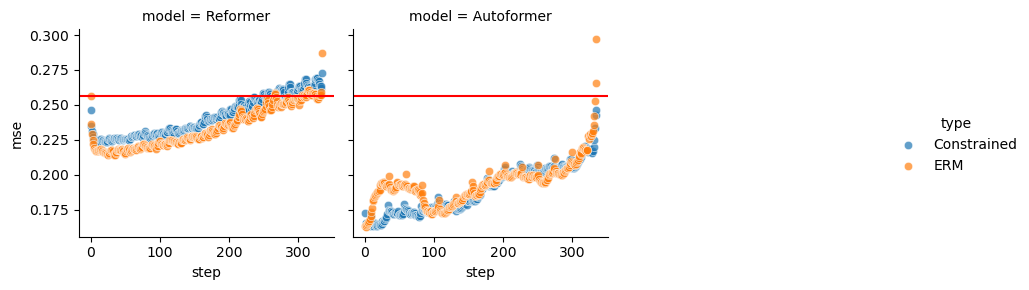

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.245

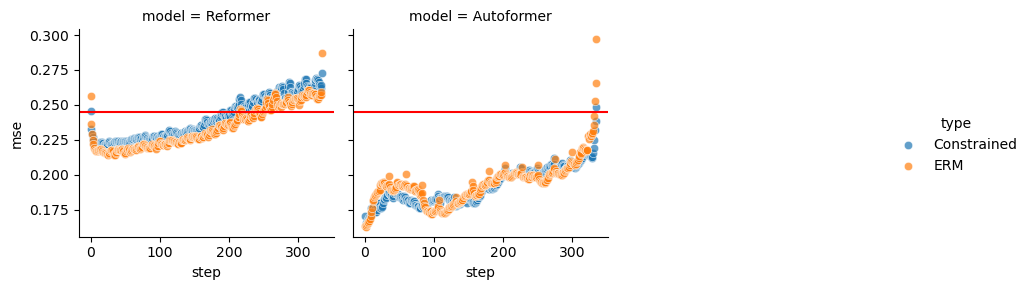

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.232

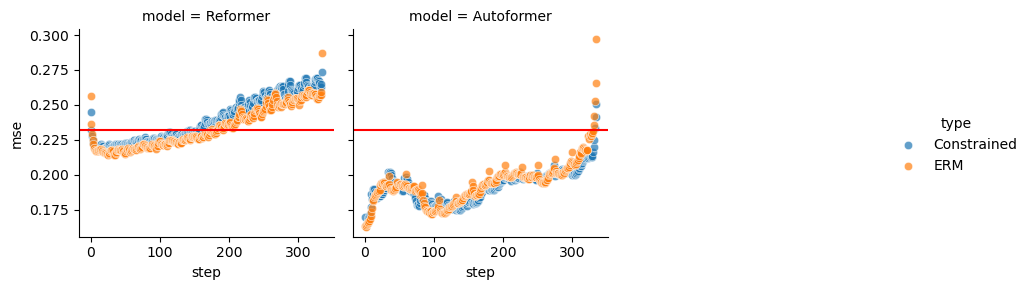

[0.246 0.23  0.215]


### Dataset: electricity.csv pred_len: 720 constraint_level: 0.246

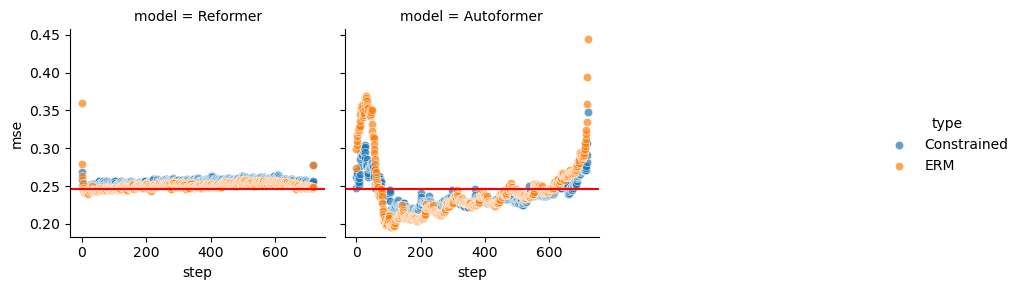

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.23

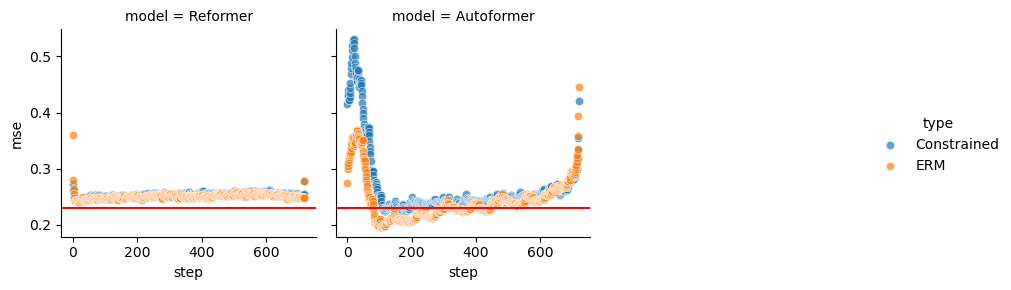

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.215

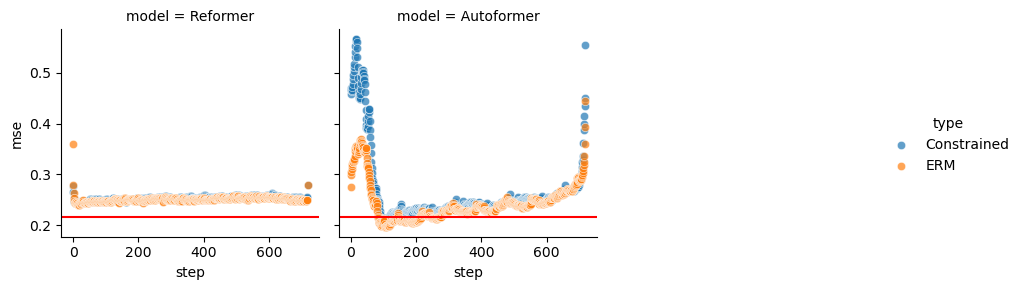

[0.556 0.553 0.516]


### Dataset: weather.csv pred_len: 96 constraint_level: 0.556

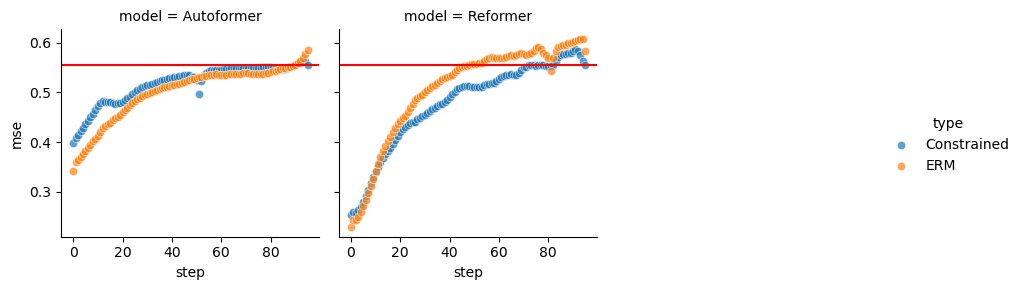

### Dataset: weather.csv pred_len: 96 constraint_level: 0.553

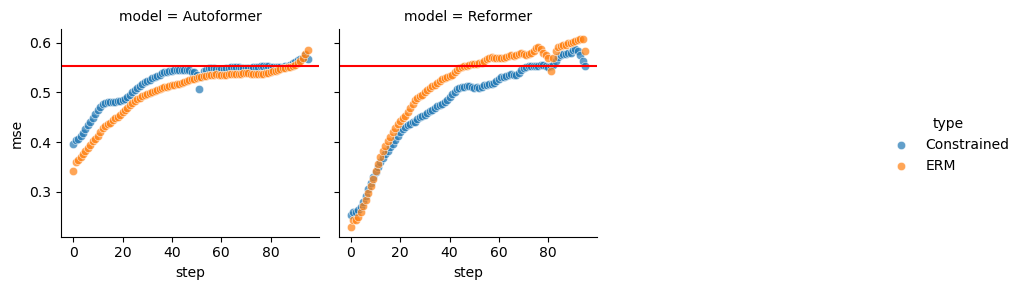

### Dataset: weather.csv pred_len: 96 constraint_level: 0.516

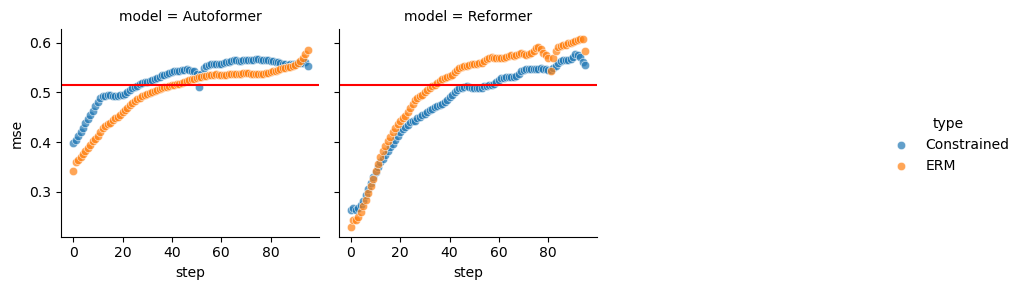

[0.665 0.567 0.553]


### Dataset: weather.csv pred_len: 192 constraint_level: 0.665

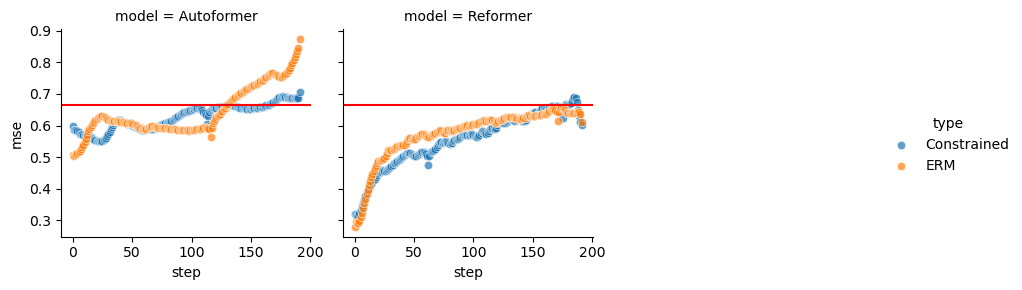

### Dataset: weather.csv pred_len: 192 constraint_level: 0.567

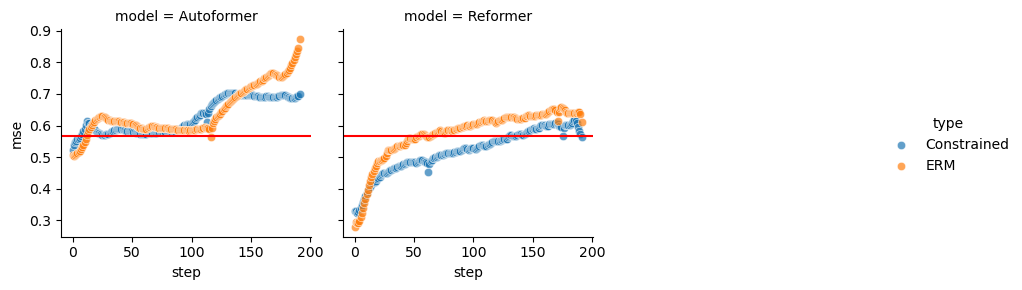

### Dataset: weather.csv pred_len: 192 constraint_level: 0.553

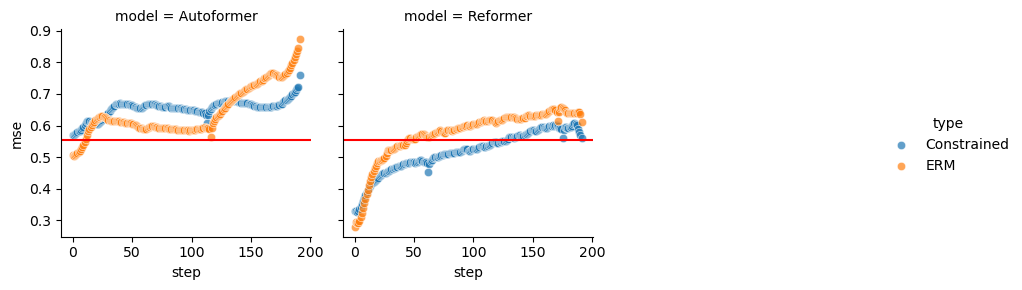

[0.97  0.741 0.682]


### Dataset: weather.csv pred_len: 336 constraint_level: 0.97

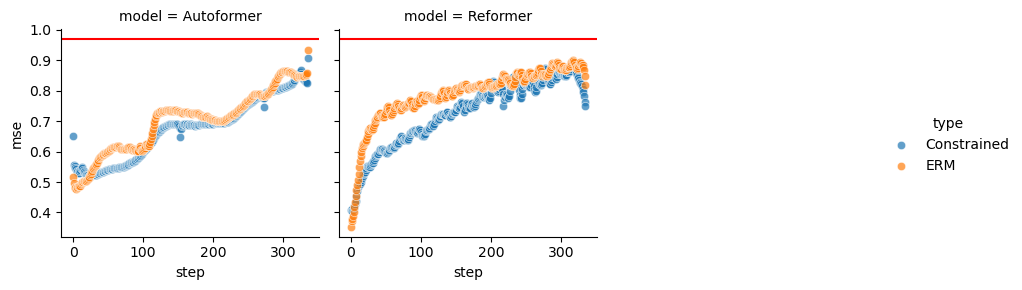

### Dataset: weather.csv pred_len: 336 constraint_level: 0.741

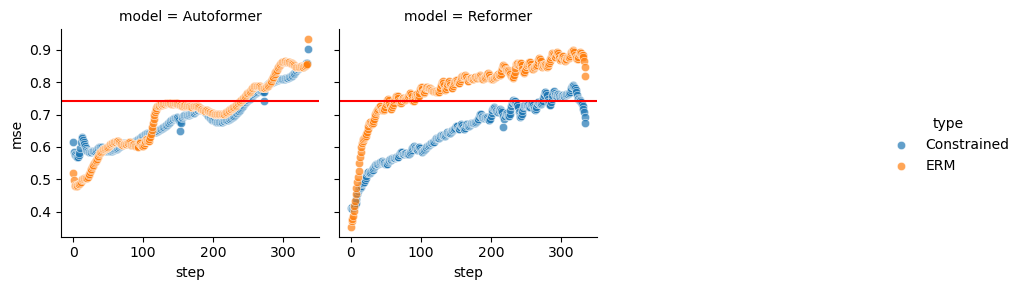

### Dataset: weather.csv pred_len: 336 constraint_level: 0.682

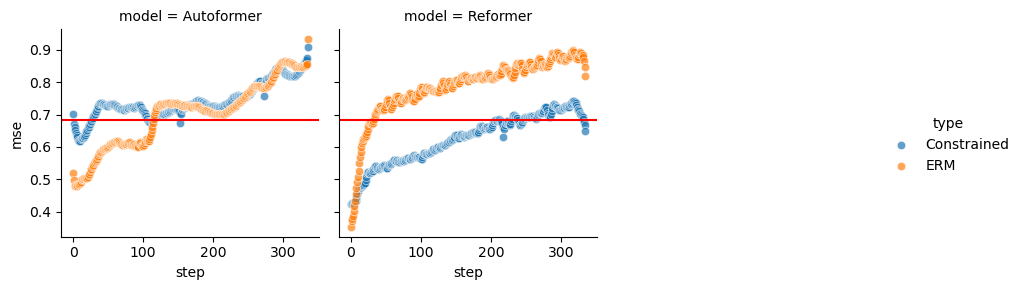

[0.912 0.862 0.698]


### Dataset: weather.csv pred_len: 720 constraint_level: 0.912

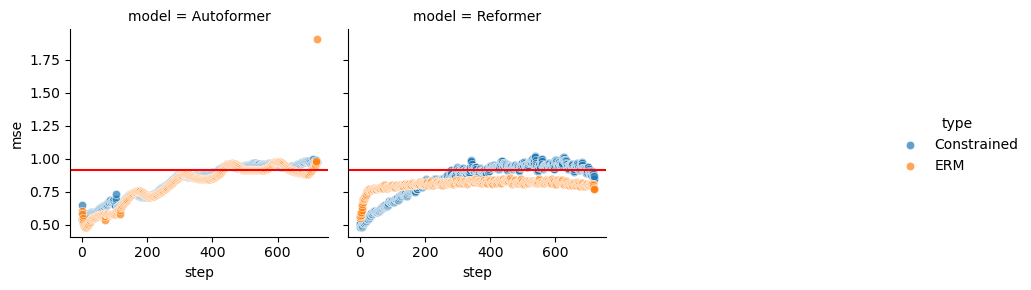

### Dataset: weather.csv pred_len: 720 constraint_level: 0.862

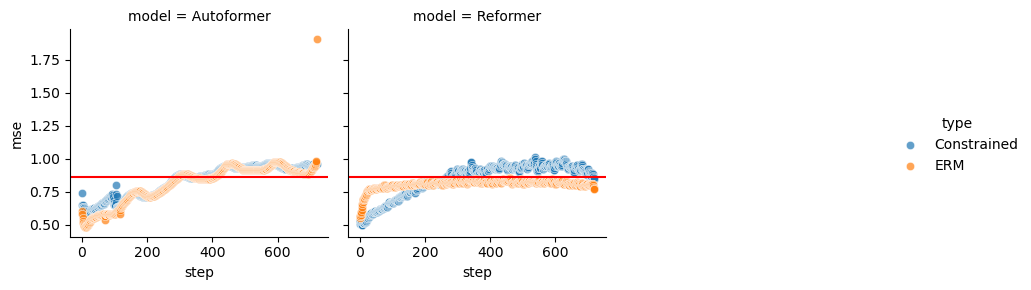

### Dataset: weather.csv pred_len: 720 constraint_level: 0.698

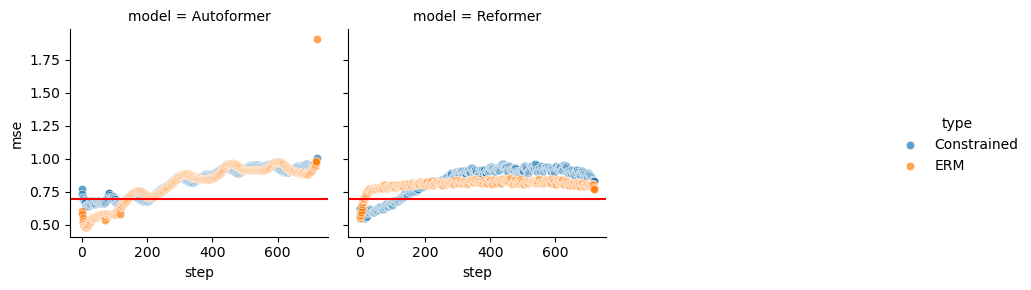

In [ ]:
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_level.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_level in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_level: {constraint_level}"))
        plot_series = series[series["constraint_level"]==constraint_level]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=3)
        g.map(sns.scatterplot, "step", "mse", alpha=.7) 
        g.add_legend()
        # add the hline
        for ax in g.axes:
            ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        g.savefig(f"figures/constrained_vs_erm_{data_path}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO ( I think Nacho already did this)

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [ ]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

,run_id,pred_len,constraint_level,data_path,model,type
68544,p9izzn2r,96,0.556,weather.csv,Reformer,Constrained
68832,b1adswkj,96,0.553,weather.csv,Reformer,Constrained
69120,dowv2wrc,96,0.516,weather.csv,Reformer,Constrained
69408,i7gx5ivx,192,0.665,weather.csv,Reformer,Constrained
69984,v4rwuch4,192,0.567,weather.csv,Reformer,Constrained
70560,mitm69y2,192,0.553,weather.csv,Reformer,Constrained
71136,chbkcq99,336,0.970,weather.csv,Reformer,Constrained
72144,749ywu49,336,0.741,weather.csv,Reformer,Constrained
73152,fe29o3il,336,0.682,weather.csv,Reformer,Constrained
74160,n1dluqy8,720,0.912,weather.csv,Reformer,Constrained


In [ ]:
constrained_runs = df_to_plot.query('type=="Constrained"').copy()
# Sum the multilpiers, fill with 0
key_cols=['run_id','model','pred_len','constraint_level','data_path']
multiplier_sum=constrained_runs.groupby(key_cols)['multiplier'].sum().reset_index()

#TO DO: plot MSE 
# get test mse
test_mses=constrained_runs.query('split=="test"').groupby(key_cols)['mse'].mean().reset_index()
mult_vs_test_mse=multiplier_sum.merge(test_mses,on=key_cols)
#sns.scatterplot(x="multiplier", y="mse", hue="constraint_level",style="pred_len", data=mult_vs_test_mse)
#g = sns.FacetGrid(mult_vs_test_mse, col="model",row='data_path',style="pred_len")
# scatterplot with hue="constraint_level",style="pred_len"
#g.map(sns.scatterplot, "multiplier", "mse", alpha=.7,)#sns.scatterplot(**args,hue="constraint_level",style="pred_len",alpha=0.3)
#g.map(sns.scatterplot, "multiplier", "mse",alpha=.7)

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

# Multipliers for window of 720

,step,split,multiplier,mse
16128,0,train,2.801533,0.209369
16129,1,train,1.050123,0.204042
16130,2,train,0.269966,0.194581
16131,3,train,0.000000,0.189056
16132,4,train,0.000000,0.187635
...,...,...,...,...
17418235,719,test,NaN,1.910884
17418236,719,test,NaN,1.910884
17418237,719,val,NaN,1.909591
17418238,719,val,NaN,1.909591


,step,multiplier,split,mse
0,0,2.801533,train,0.209369
1,0,2.801533,test,0.268508
2,0,2.801533,val,0.266284
3,0,2.801533,train,0.215619
4,0,2.801533,test,0.247226
...,...,...,...,...
17418235,719,NaN,test,1.910884
17418236,719,NaN,test,1.910884
17418237,719,NaN,val,1.909591
17418238,719,NaN,val,1.909591


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fedbc19fa70> (for post_execute):


KeyboardInterrupt: 

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fedbc19f4d0> (for post_execute):


KeyboardInterrupt: 

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

,Algorithm,model,type,constraint_level,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,run_count
0,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,test,0.161314,0.008300,0.005958,0.006300,3
1,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,train,0.122875,0.008124,0.000137,0.001351,3
2,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.157,96,electricity.csv,val,0.161379,0.008284,0.006002,0.006303,3
3,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,test,0.175690,0.021071,0.011387,0.017147,3
4,Electricity-StatInformed-10e-Constrained Autof...,Autoformer,Constrained,0.169,96,electricity.csv,train,0.127490,0.007203,0.000018,0.000296,3
...,...,...,...,...,...,...,...,...,...,...,...,...
283,StatInformed-ERM-10e Reformer,Reformer,ERM,0.912,720,weather.csv,train,0.284454,0.003977,0.000000,0.000000,3
284,StatInformed-ERM-10e Reformer,Reformer,ERM,0.912,720,weather.csv,val,0.868256,0.071528,0.014379,0.025065,3
285,StatInformed-ERM-10e Reformer,Reformer,ERM,0.970,336,weather.csv,test,0.769636,0.090134,0.000000,0.000000,3
286,StatInformed-ERM-10e Reformer,Reformer,ERM,0.970,336,weather.csv,train,0.317969,0.010492,0.000000,0.000000,3


In [77]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_metrics.query('data_path=="weather.csv"').copy()
electricity = summary_metrics.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_level'], 
        columns=['type','model'], 
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:            
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

# weather

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                 0.4787     0.4482      0.4345   0.4380   
         0.553                 0.4756     0.4482      0.4377   0.4380   
         0.556                 0.4748     0.4482      0.4380   0.4380   
192      0.553                 0.6139     0.5941      0.4737   0.4877   
         0.567                 0.5868     0.5941      0.4767   0.4877   
         0.665                 0.5952     0.5941      0.5055   0.4877   
336      0.682                 0.7118     0.6704      0.5596   0.6312   
         0.741                 0.6518     0.6704      0.5794   0.6312   
         0.970                 0.6572     0.6704      0.6335   0.6312   
720      0.698                 0.7879     0.7840      0.7066   0.6350   
         0.862                 0.7923     0.7840      0.7185   0.6350   
         0.912                 0.7926     0.7840      0.7234   0.6350   

                              std_mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                    NaN        NaN         NaN      NaN   
         0.553                    NaN        NaN         NaN      NaN   
         0.556                    NaN        NaN         NaN      NaN   
192      0.553                    NaN        NaN         NaN      NaN   
         0.567                    NaN        NaN         NaN      NaN   
         0.665                    NaN        NaN         NaN      NaN   
336      0.682                    NaN        NaN         NaN      NaN   
         0.741                    NaN        NaN         NaN      NaN   
         0.970                    NaN        NaN         NaN      NaN   
720      0.698                    NaN        NaN         NaN      NaN   
         0.862                    NaN        NaN         NaN      NaN   
         0.912                    NaN        NaN         NaN      NaN   

                                  mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                 0.0171     0.0089      0.0086   0.0231   
         0.553                 0.0007     0.0006      0.0021   0.0089   
         0.556                 0.0001     0.0005      0.0018   0.0079   
192      0.553                 0.0681     0.0748      0.0071   0.0296   
         0.567                 0.0420     0.0642      0.0054   0.0227   
         0.665                 0.0018     0.0190      0.0004   0.0000   
336      0.682                 0.0420     0.0424      0.0052   0.0779   
         0.741                 0.0109     0.0165      0.0022   0.0436   
         0.970                 0.0000     0.0000      0.0000   0.0000   
720      0.698                 0.0980     0.1171      0.1006   0.0757   
         0.862                 0.0242     0.0212      0.0279   0.0000   
         0.912                 0.0116     0.0069      0.0116   0.0000   

                              std_mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                    NaN        NaN         NaN      NaN   
         0.553                    NaN        NaN         NaN      NaN   
         0.556                    NaN        NaN         NaN      NaN   
192      0.553  

# electricity

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                 0.1507     0.1400      0.1824   0.1881   
         0.169                 0.1541     0.1400      0.1832   0.1881   
         0.170                 0.1520     0.1400      0.1833   0.1881   
192      0.173                 0.1763     0.1827      0.2074   0.2150   
         0.184                 0.1742     0.1827      0.2086   0.2150   
         0.200                 0.1798     0.1827      0.2108   0.2150   
336      0.232                 0.1849     0.1832      0.2163   0.2112   
         0.245                 0.1869     0.1832      0.2177   0.2112   
         0.256                 0.1851     0.1832      0.2192   0.2112   
720      0.215                 0.2379     0.2235      0.2284   0.2250   
         0.230                 0.2400     0.2235      0.2295   0.2250   
         0.246                 0.2241     0.2235      0.2325   0.2250   

                              std_mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                    NaN        NaN         NaN      NaN   
         0.169                    NaN        NaN         NaN      NaN   
         0.170                    NaN        NaN         NaN      NaN   
192      0.173                    NaN        NaN         NaN      NaN   
         0.184                    NaN        NaN         NaN      NaN   
         0.200                    NaN        NaN         NaN      NaN   
336      0.232                    NaN        NaN         NaN      NaN   
         0.245                    NaN        NaN         NaN      NaN   
         0.256                    NaN        NaN         NaN      NaN   
720      0.215                    NaN        NaN         NaN      NaN   
         0.230                    NaN        NaN         NaN      NaN   
         0.246                    NaN        NaN         NaN      NaN   

                                  mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                 0.0047     0.0012      0.0289   0.0328   
         0.169                 0.0013     0.0004      0.0212   0.0247   
         0.170                 0.0009     0.0004      0.0206   0.0240   
192      0.173                 0.0126     0.0180      0.0400   0.0463   
         0.184                 0.0044     0.0105      0.0334   0.0390   
         0.200                 0.0037     0.0033      0.0243   0.0283   
336      0.232                 0.0001     0.0003      0.0073   0.0048   
         0.245                 0.0000     0.0002      0.0031   0.0016   
         0.256                 0.0000     0.0001      0.0009   0.0002   
720      0.215                 0.0335     0.0210      0.0253   0.0239   
         0.230                 0.0246     0.0135      0.0158   0.0139   
         0.246                 0.0031     0.0084      0.0070   0.0033   

                              std_mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                    NaN        NaN         NaN      NaN   
         0.169                    NaN        NaN         NaN      NaN   
         0.170                    NaN        NaN         NaN      NaN   
192      0.173  

## Pivots per dataset